### Machine Learning for Engineers: [ImbalancedData](https://www.apmonitor.com/pds/index.php/Main/ImbalancedData)
- [Imbalanced Data and Learning](https://www.apmonitor.com/pds/index.php/Main/ImbalancedData)
 - Source Blocks: 6
 - Description: Identify imbalanced data and use undersampling or oversampling to improve the machine learning classification results.
- [Course Overview](https://apmonitor.com/pds)
- [Course Schedule](https://apmonitor.com/pds/index.php/Main/CourseSchedule)

<img width=400px align=left src='https://apmonitor.com/pds/uploads/Main/imbalanced_data.png'>

In [2]:
#pip install imblearn

In [1]:
#pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler as RUS
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import make_blobs as MB

### Import Data with Weighted Classes

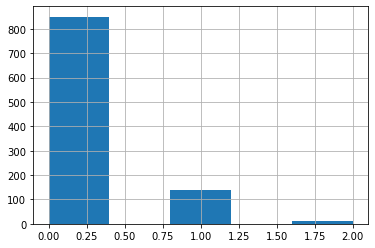

0         1         2         3         4  label
0 -10.800342  3.172799  5.239638  7.307207  5.994013      0
1 -14.990925  3.017590  3.977746  5.360931  4.784813      0
2 -11.717584  1.484062  6.603974  7.225007  3.876819      0
3 -11.451783  2.013037  5.301218  7.659808  8.734456      2
4 -10.977639  4.676936  6.553846  7.233869  4.575602      0

In [4]:
data = pd.read_csv('http://apmonitor.com/pds/uploads/Main/imbalanced_train.csv')
datat = pd.read_csv('http://apmonitor.com/pds/uploads/Main/imbalanced_test.csv')
data.columns = [0,1,2,3,4,'label']
datat.columns = [0,1,2,3,4,'label']
data['label'].hist(bins=5)
plt.show()
data.head()

### Visualize Data

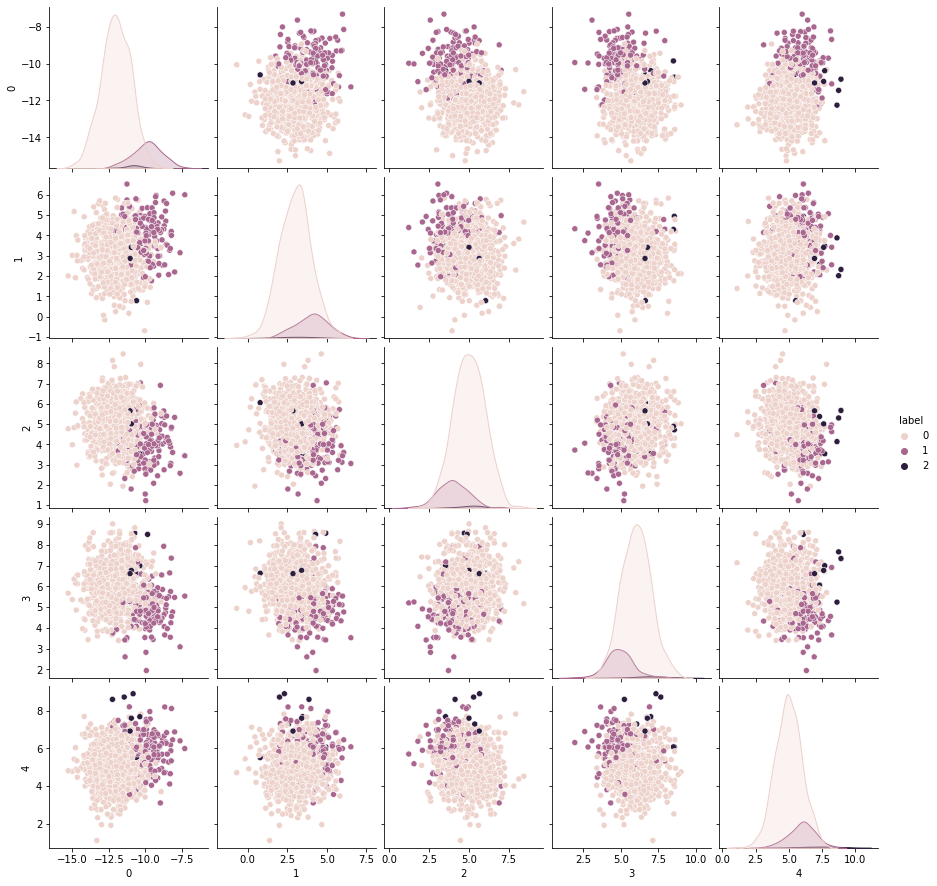

In [5]:
sns.pairplot(data,hue='label')
plt.show()

### Find and drop redundant columns

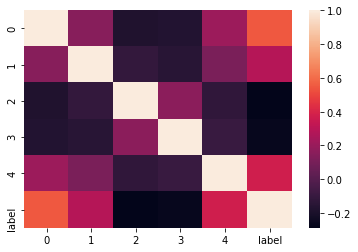

In [6]:
sns.heatmap(data.corr())
plt.show()

In this case, none of the columns show great correlation so we will use all features

### Create Models
#### Make One Model Weighted, and One Unweighted

In order to "weight" a model, there are several approaches one can take. Oversampling the minority classes or undersampling the majority classes is one way to try to "fill" imbalanced data. When oversampling minority classes, typically methods such as SMOTE are used. SMOTE creates artificial samples of a class with features within the vector space of the other class samples. Another approach, which is not shown here, is to use the "weights" kwarg that many model classes have. These accept some coefficient array that tells the model to adjust itself to compensate for imbalances. Reproportion the data to be the same quantity for each class by oversampling the minority and undersampling the majority.

In [7]:
Xtrain = data[[0,1,2,3,4]]
ytrain = data['label']
Xtest = datat[[0,1,2,3,4]]
ytest = datat['label']
fa = np.count_nonzero(ytrain.values==2)*2

ov = {0:int(np.count_nonzero(ytrain.values==0)),\
      1:int(np.count_nonzero(ytrain.values==1)),\
      2:int(fa)} #oversample the smallest class
un = {0:fa,1:fa,2:fa} #sample the same number of samples for each class
                      # so the population is roughly equal
over = SMOTE(sampling_strategy=ov, random_state=4, k_neighbors = 4)
under = RUS(sampling_strategy=un, random_state=4)
model_weighted = xgb.XGBClassifier(use_label_encoder=False)
model_imb = xgb.XGBClassifier(use_label_encoder=False)
# model_sampled = 
model_imb.fit(Xtrain,ytrain)
steps = [ ('o',over),('u',under),('xgboost',model_weighted)] #
pipeline = Pipeline(steps)
pipeline.fit(Xtrain,ytrain)
# yp = pipline.predict(Xtest)
pass

[10:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Visualize Results

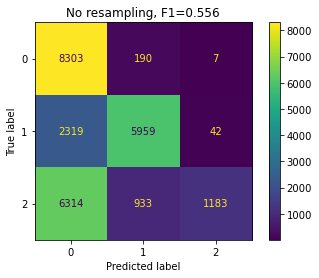

True quantities: 0:8500 1:{np.count_nonzero(ytest.values==1)} 2:{np.count_nonzero(ytest.values==2)}


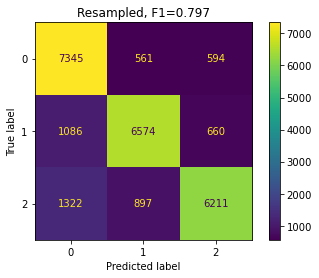

In [8]:
ConfusionMatrixDisplay.from_estimator(model_imb,Xtest,ytest)
plt.title(f'No resampling, F1={f1_score(ytest,model_imb.predict(Xtest),average="weighted"):.3g}')
plt.show()
print(f'True quantities: 0:{np.count_nonzero(ytest.values==0)} ' + \
      '1:{np.count_nonzero(ytest.values==1)} ' + \
      '2:{np.count_nonzero(ytest.values==2)}')
ConfusionMatrixDisplay.from_estimator(pipeline,Xtest,ytest)
plt.title(f'Resampled, F1={f1_score(ytest,pipeline.predict(Xtest),average="weighted"):.3g}')
plt.show()

### Conclusion

The  model trained on the resampled data predicted the smaller classes more often than the model trained on the skewed data. This leads to more misclassification of the majority class, but improves the classification of the minority class. 